In [1]:
## Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans  
from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# Importing the dataset
data = pd.read_csv('oscars-demographics.csv', encoding ='mac-roman')
dataset = data[['birthplace','date_of_birth','race_ethnicity','year_of_award','award']]
dataset.head(3)
dataset_2= data[['sexual_orientation','movie','religion','person']]


## Web scraping to pull in the gender to improve our model

In [2]:
def extraFeatures(link):
    import requests
    from bs4 import BeautifulSoup
    page = requests.get(link)
    soup = BeautifulSoup(page.content)
#using if else statements we search the page for bold text of Gender 
    if soup.findAll("p")[2].findAll("b")[0].text == 'Gender:' :
        para = soup.findAll("p")[2]
        lis = str(para).split("br/>")
    elif soup.findAll("p")[1].findAll("b")[0].text == 'Gender:' :
        para = soup.findAll("p")[1]
        lis = str(para).split("<br/>")
    else:
        lis = []

    return lis

features = data.biourl.apply(lambda url:extraFeatures(url))
 
extrafeaturedataset = pd.concat((data.biourl, features.rename('Feature')), axis=1)
 
extrafeaturedataset.to_csv("extraDataset.csv")#we put scrapped data into new csv file 

## Reading in from our new CSV file

In [3]:
extrafeaturedataset =pd.read_csv("extraDataset.csv")

extrafeaturedataset.head(3)

,Unnamed: 0,biourl,Feature
0,0,http://www.nndb.com/people/320/000043191/,"['<p><b>Gender:</b> Male<', '<b>Race or Ethnic..."
1,1,http://www.nndb.com/people/626/000042500/,"['<p><b>Gender:</b> Male', '<b>Race or Ethnici..."
2,2,http://www.nndb.com/people/320/000043191/,"['<p><b>Gender:</b> Male<', '<b>Race or Ethnic..."
3,3,http://www.nndb.com/people/544/000041421/,"['<p><b>Gender:</b> Male', '<b>Race or Ethnici..."
4,4,http://www.nndb.com/people/292/000044160/,"['<p><b>Gender:</b> Male', '<b>Religion:</b> <..."
...,...,...,...
436,436,http://www.nndb.com/people/309/000032213/,"['<p><b>Gender:</b> Female', '<b>Religion:</b>..."
437,437,http://www.nndb.com/people/887/000044755/,"['<p><b>Gender:</b> Male<', '<b>Religion:</b> ..."
438,438,http://www.nndb.com/people/224/000032128/,"['<p><b>Gender:</b> Male<', '<b>Race or Ethnic..."
439,439,http://www.nndb.com/people/764/000022698/,"['<p><b>Gender:</b> Male<', '<b>Race or Ethnic..."


In [4]:
import ast

In [5]:
extrafeaturedataset.Feature = extrafeaturedataset.Feature.apply(lambda txt: ast.literal_eval(txt))
extrafeaturedataset['Gender'] = extrafeaturedataset.Feature.apply(lambda txt: txt[0].split(' ')[1].replace("'",""))


In [1]:
extrafeaturedataset.head(3)

NameError: name 'extrafeaturedataset' is not defined

In [7]:
#we add gender to our datatset to be used for analysis
dataset = pd.concat((dataset,extrafeaturedataset.Gender.rename('gender')),axis=1)


In [8]:
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male<
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director,Male
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male<
3,"Chicago, Il",23-Feb-1899,White,1932,Best Director,Male
4,"Salt Lake City, Ut",23-Apr-1894,White,1933,Best Director,Male
...,...,...,...,...,...,...
436,"London, England",07-Mar-71,White,2006,Best Supporting Actress,Female
437,"Manchester, England",20-Oct-56,White,2009,Best Director,Male<
438,"Chicago, Il",26-Jul-22,White,1977,Best Supporting Actor,Male<
439,"Laurel, Ne",31-Aug-28,White,1999,Best Supporting Actor,Male<


## Cleaning our gender column 

In [9]:
gender = dataset['gender']

def genderCleaning(x):
    if "Male<" in x :
        return "Male"
    else:
        return "Female"


dataset['gender'] = gender.apply(lambda txt:genderCleaning(txt))

dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director,Female
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male
3,"Chicago, Il",23-Feb-1899,White,1932,Best Director,Female
4,"Salt Lake City, Ut",23-Apr-1894,White,1933,Best Director,Female
...,...,...,...,...,...,...
436,"London, England",07-Mar-71,White,2006,Best Supporting Actress,Female
437,"Manchester, England",20-Oct-56,White,2009,Best Director,Male
438,"Chicago, Il",26-Jul-22,White,1977,Best Supporting Actor,Male
439,"Laurel, Ne",31-Aug-28,White,1999,Best Supporting Actor,Male


In [10]:
'''#here we get the length of date_of_birth and assign in to the new column ldob 
for index, row in dataset.iterrows():
    dataset.loc[index, 'ldob'] = len(row['date_of_birth'])'''
    
#here we get the length of date_of_birth and assign in to the new column ldob 
dataset['ldob'] = dataset.date_of_birth.apply(len) 

print(dataset['ldob'])

0      11
1      10
2      11
3      11
4      11
       ..
436     9
437     9
438     9
439     9
440     9
Name: ldob, Length: 441, dtype: int64


In [11]:
dataset = dataset.drop([54, 84, 246, 249], axis=0) 

In [12]:
dataset['ldob'] = dataset['ldob'].astype(int)

In [13]:
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director,Female,10
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11


In [14]:
def checker_2(value):
    y = re.search("(?<=(\d{2})-(\D{3})-)(\d{2})(?=$)", value)
    if y:
        pos = y.span()
        year= y.group(0)
        return value[:pos[0]] + "19" + year
    else:
        return value

dataset.date_of_birth=dataset.date_of_birth.apply(lambda y: checker_2(y))



In [15]:
def checker(value):
    '''r it just tells python the regular expression is in a raw format 
    \b checks if the day has only one number \w checks if it is a word in the month space ?= checks the front (look ahead)
    ''' 
    x = re.search(r"(\b\d{1})(?=-(\w{3})-\d{4})", value) 
    if x:
        pos = x.span()#finds out the position of the matched value 
        day = x.group(0)#group(0) takes the first match 
        return "0" + day + value[pos[0] + 1:]#removes initial single digit day from date, then concatenates regex search results with new day.
    else:
        return value
dataset.date_of_birth=dataset.date_of_birth.apply(lambda x: checker(x))


In [16]:


for index, row in dataset.iterrows():
    state = row["birthplace"].rsplit(',', 1)[0]
    country = row["birthplace"].split(',')[-1].strip()
    
    if len(country) == 2: 
        country = "USA"
    else:
        country = country  
        
    dataset.loc[index,'country'] = country
    dataset.loc[index, 'birthplace'] = state + ", " + country 
      


In [17]:
#dataset = dataset.drop([84,54], axis=0)

In [18]:
for index, row in dataset.iterrows():
    dataset.loc[index, 'ldob'] = len(row['date_of_birth'])


In [19]:
'''for index, row in dataset.iterrows():
    year_of_birth = row['date_of_birth'].split('-')[2] #Get year of birth from the date of birth
    dataset.loc[index,'award_age'] = int(row['year_of_award']) - int(year_of_birth)# add a new column award_age created from the subtraction of the year of birth from the year of award'''
#Get award age
dataset['award_age'] = dataset.apply(lambda row:np.subtract(row['year_of_award'],int(row['date_of_birth'].split('-')[2])), axis=1)


In [20]:
#dataset['award_age'] = dataset['award_age'].astype(int)

In [21]:
dataset.shape

(437, 9)

In [22]:

#adding extra data to be used to improve our model
dataset['sexual_orientation']=dataset_2['sexual_orientation']
dataset['movie']=dataset_2['movie']  
dataset['religion']=dataset_2['religion'] 
dataset['person']=dataset_2['person']




In [23]:
#here we remove the duplicates in our dataset 
dataset.drop_duplicates()


,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age,sexual_orientation,movie,religion,person
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32,Straight,Two Arabian Knights,Na,Lewis Milestone
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,11,Scotland,44,Straight,The Divine Lady,Na,Frank Lloyd
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36,Straight,All Quiet on the Western Front,Na,Lewis Milestone
3,"Chicago, USA",23-Feb-1899,White,1932,Best Director,Female,11,USA,33,Straight,Skippy,Na,Norman Taurog
4,"Salt Lake City, USA",23-Apr-1894,White,1933,Best Director,Female,11,USA,39,Straight,Bad Girl,Roman Catholic,Frank Borzage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,"Woodlawn, USA",11-Dec-1967,Black,2010,Best Supporting Actress,Female,11,USA,43,Straight,Precious,Na,Mo'Nique
412,"New York City, New York City",14-Sep-1960,White,2011,Best Supporting Actress,Female,11,New York City,51,Straight,The Fighter,Na,Melissa Leo
413,"Montgomery, USA",25-May-1972,Black,2012,Best Supporting Actress,Female,11,USA,40,Na,The Help,Na,Octavia Spencer
414,"Brooklyn, USA",12-Nov-1982,White,2013,Best Supporting Actress,Female,11,USA,31,Straight,Les Misí©rables,Christian,Anne Hathaway


In [24]:
#replace missing data 
dataset.fillna(method="ffill")


,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age,sexual_orientation,movie,religion,person
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32,Straight,Two Arabian Knights,Na,Lewis Milestone
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,11,Scotland,44,Straight,The Divine Lady,Na,Frank Lloyd
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36,Straight,All Quiet on the Western Front,Na,Lewis Milestone
3,"Chicago, USA",23-Feb-1899,White,1932,Best Director,Female,11,USA,33,Straight,Skippy,Na,Norman Taurog
4,"Salt Lake City, USA",23-Apr-1894,White,1933,Best Director,Female,11,USA,39,Straight,Bad Girl,Roman Catholic,Frank Borzage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,"London, England",07-Mar-1971,White,2006,Best Supporting Actress,Female,11,England,35,Straight,The Constant Gardener,Jewish,Rachel Weisz
437,"Manchester, England",20-Oct-1956,White,2009,Best Director,Male,11,England,53,Straight,Slumdog Millionaire,Roman Catholic,Danny Boyle
438,"Chicago, USA",26-Jul-1922,White,1977,Best Supporting Actor,Male,11,USA,55,Straight,All the President's Men,Na,Jason Robards
439,"Laurel, USA",31-Aug-1928,White,1999,Best Supporting Actor,Male,11,USA,71,Straight,Affliction,Na,James Coburn


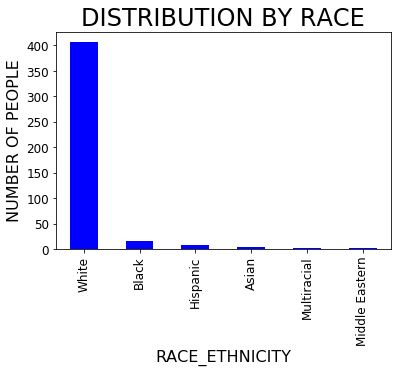

In [25]:
#Most Oscar winners are white. 
def plotdata(data, col, title): 
    #group data 
    grouped_data = data[col].value_counts() 
    #plot graph 
    grouped_data.plot(kind='bar', fontsize=12,color='b') 
    #name the x axis and let the fontsize equals to 16px 
    plt.xlabel( col.upper(), fontsize=16) 
    #name the y axis and let the fontsize equals to 16px 
    plt.ylabel('Number of People'.upper(),fontsize=16) 
    #give the title a name and give it a font-size of 24px 
    plt.title(title.upper(), fontsize=24) 
    plt.show() 
plotdata(dataset,'race_ethnicity', 'distribution by race') 

Text(0.5, 1.0, 'DISTRIBUTION BY COUNTRY')

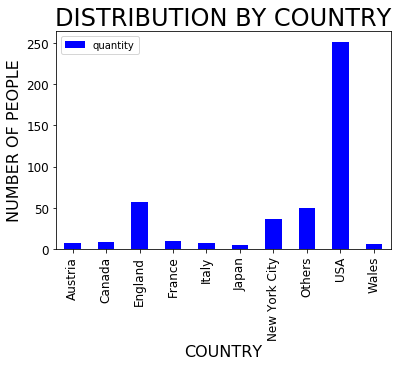

In [26]:
#Most Oscar winners are from USA 
n = 4 
#group country data and rename the columns 
grouped_data = dataset['country'].value_counts().rename_axis('country').reset_index(name='quantity') 
#if country data is less than n, change column name to 'others'  
grouped_data.loc[grouped_data.quantity <= n , 'country'] = 'Others' 
# regroup country data 
new_grouped_data = grouped_data.groupby('country').sum() 
#plot graph of new grouped data and give the bars a color of blue 
new_grouped_data.plot(kind='bar', fontsize=12,color='b') 
#name the x axis and let the fontsize equals to 16px 
plt.xlabel( 'country'.upper(), fontsize=16) 
#name the y axis and let the fontsize equals to 16px 
plt.ylabel('Number of People'.upper(),fontsize=16) 
#give the title a name and give it a font-size of 24px 
plt.title('distribution by country'.upper(), fontsize=24) 

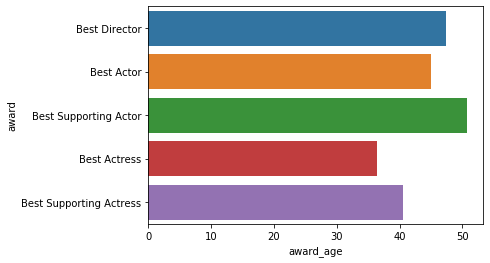

In [27]:
#Best Directors tend to be older than best Actors or Actresses. 
#set x to award_age column 
x = dataset.award_age 
#set y to award column 
y = dataset.award 
#plot graph using seaborn  
sns.barplot(x=x,y=y, ci=None) 
 

## Discretizing our age

In [28]:
age_buckets = []
age = list(dataset['award_age'])
for i in range(len(age)):
    if age[i] < 35 :#any ages below 35 have been replaced with 1 
        age_buckets.append(1)
    elif age[i] < 45 :#ages between 35 to 44 have been replaced with 2
        age_buckets.append(2)
    elif age[i] < 55 :#ages between 45 to 54 have been replaced with 3
        age_buckets.append(3)
    else:#ages from 55 upwards have been replaced with 4
        age_buckets.append(4)


In [29]:
dataset['age_buckets'] = age_buckets
dataset

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age,sexual_orientation,movie,religion,person,age_buckets
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32,Straight,Two Arabian Knights,Na,Lewis Milestone,1
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,11,Scotland,44,Straight,The Divine Lady,Na,Frank Lloyd,2
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36,Straight,All Quiet on the Western Front,Na,Lewis Milestone,2
3,"Chicago, USA",23-Feb-1899,White,1932,Best Director,Female,11,USA,33,Straight,Skippy,Na,Norman Taurog,1
4,"Salt Lake City, USA",23-Apr-1894,White,1933,Best Director,Female,11,USA,39,Straight,Bad Girl,Roman Catholic,Frank Borzage,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,"London, England",07-Mar-1971,White,2006,Best Supporting Actress,Female,11,England,35,Straight,The Constant Gardener,Jewish,Rachel Weisz,2
437,"Manchester, England",20-Oct-1956,White,2009,Best Director,Male,11,England,53,Straight,Slumdog Millionaire,Roman Catholic,Danny Boyle,3
438,"Chicago, USA",26-Jul-1922,White,1977,Best Supporting Actor,Male,11,USA,55,Straight,All the President's Men,Na,Jason Robards,4
439,"Laurel, USA",31-Aug-1928,White,1999,Best Supporting Actor,Male,11,USA,71,Straight,Affliction,Na,James Coburn,4


## Building our model

In [30]:
# split the data into train and test set
import matplotlib.pyplot as plt  

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

X=dataset[['race_ethnicity','country','award_age']]

X=pd.get_dummies(X,columns=['race_ethnicity','country'])

y=dataset['award']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2,test_size=0.2)



## Training the Logistic Regression model on the Training set

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0)

clf.fit(X_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy score for training data is: 0.444
Accuracy score for test data: 0.352


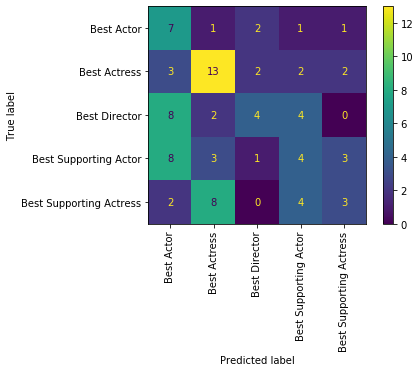

Cross validation mean score: 0.3611257928118393
Cross validation scores [0.25       0.34090909 0.45454545 0.29545455 0.43181818 0.34883721
 0.37209302 0.39534884]


In [32]:
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

from sklearn.model_selection import KFold, cross_val_score
from sklearn import feature_selection, linear_model, model_selection
scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean score: {}".format(scores.mean()))
print("Cross validation scores", scores)

## Training the K-NN model on the Training set

In [33]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Accuracy score for training data is: 0.513
Accuracy score for test data: 0.330


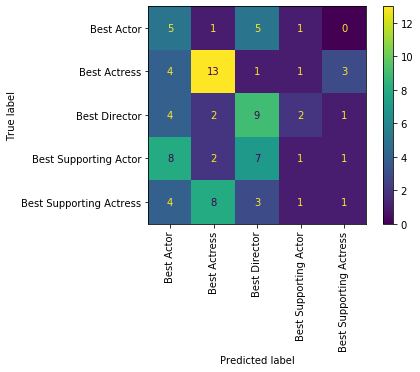

Cross validation mean scores:0.32386363636363635
Cross validation mean scores: [0.25       0.36363636 0.36363636 0.34090909 0.27272727 0.27906977
 0.3255814  0.39534884]


In [34]:
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))

print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean scores:{}".format(scores.mean()))
print("Cross validation mean scores:",scores)

## Training the random forest model on the training set 

Accuracy score for training data is: 0.513
Accuracy score for test data: 0.330


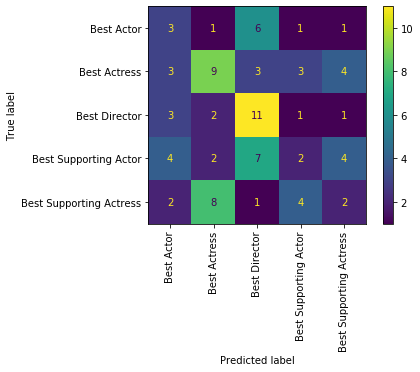

Cross validation mean scores:0.35273520084566595
Cross validation mean scores: [0.25       0.36363636 0.38636364 0.29545455 0.36363636 0.39534884
 0.3255814  0.44186047]


In [35]:
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()


scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean scores:{}".format(scores.mean()))
print("Cross validation mean scores:",scores)

## IMPROVING OUR MODEL 

## USING FEATURE SELECTION TO DETERMINE THE BEST FEATURES TO USE FROM OUR DATASET

In [37]:

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import OrdinalEncoder



dataset_test= dataset


ord_enc = OrdinalEncoder()
dataset_test["religion"] = ord_enc.fit_transform(dataset_test[["religion"]])
dataset_test["race_ethnicity"] = ord_enc.fit_transform(dataset_test[["race_ethnicity"]])
dataset_test["country"] = ord_enc.fit_transform(dataset_test[["country"]])
dataset_test["sexual_orientation"] = ord_enc.fit_transform(dataset_test[["sexual_orientation"]])
dataset_test["movie"] = ord_enc.fit_transform(dataset_test[["movie"]])
dataset_test["person"] = ord_enc.fit_transform(dataset_test[["person"]])
dataset_test["award_age"] = ord_enc.fit_transform(dataset_test[["award_age"]])
dataset_test["gender"] = ord_enc.fit_transform(dataset_test[["gender"]])



dataset_test.head(11)


X = dataset_test[['race_ethnicity','country','award_age','sexual_orientation','religion', 'movie', 'person','gender']]  #independent columns
y = dataset_test['award']    #target column i.e price range
print(X)

#print(y)
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print 10 best features 







     race_ethnicity  country  award_age  sexual_orientation  religion  movie  \
0               5.0     18.0       14.0                 5.0      15.0  317.0   
1               5.0     24.0       26.0                 5.0      15.0  242.0   
2               5.0     18.0       18.0                 5.0      15.0   21.0   
3               5.0     31.0       15.0                 5.0      15.0  209.0   
4               5.0     31.0       21.0                 5.0      19.0   34.0   
..              ...      ...        ...                 ...       ...    ...   
436             5.0      7.0       17.0                 5.0      12.0  236.0   
437             5.0      7.0       35.0                 5.0      19.0  210.0   
438             5.0     31.0       37.0                 5.0      15.0   24.0   
439             5.0     31.0       52.0                 5.0      15.0   17.0   
440             5.0     31.0       25.0                 5.0      15.0  299.0   

     person  gender  
0     208.0     1

## Training the Logistic Regression model on the Training set with an added column

In [56]:
# split the data into train and test set
X=dataset[['race_ethnicity','country','award_age','religion','sexual_orientation','gender']]
X=pd.get_dummies(X,columns=['race_ethnicity','country','religion','sexual_orientation','gender'])
y=dataset['award']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,test_size=0.2)

In [57]:
#importing our logistic regressor 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy score for training data is: 0.642
Accuracy score for test data: 0.557
Cross validation mean scores: 0.46478594080338265
Cross validation mean scores: [0.40909091 0.43181818 0.38636364 0.43181818 0.45454545 0.55813953
 0.60465116 0.44186047]


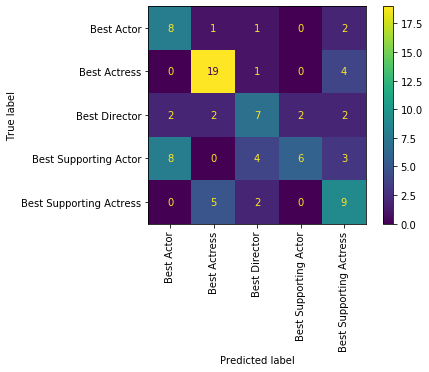

In [59]:
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))

print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

from sklearn.model_selection import KFold, cross_val_score
from sklearn import feature_selection, linear_model, model_selection

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean scores: {}".format(scores.mean()))
print("Cross validation mean scores:",scores)
plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

## Training the K-NN model on the Training set with an added column

In [64]:
from sklearn.neighbors import KNeighborsClassifier

X=dataset[['race_ethnicity','country','award_age','religion','gender']]

X=pd.get_dummies(X,columns=['race_ethnicity','country','religion','gender'])

y=dataset['award']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,test_size=0.2)

clf = KNeighborsClassifier(n_neighbors=2)

clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

Cross validation mean scores: 0.38682610993657507
Cross validation mean scores: [0.45454545 0.36363636 0.40909091 0.36363636 0.34090909 0.34883721
 0.37209302 0.44186047]


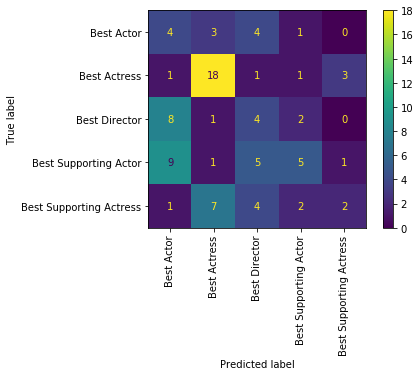

Accuracy score for training data is: 0.670
Accuracy score for test data: 0.375


In [65]:

from sklearn.model_selection import KFold, cross_val_score
from sklearn import feature_selection, linear_model, model_selection

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)

#displaying the value of our cross validation 
print("Cross validation mean scores: {}".format(scores.mean()))
print("Cross validation mean scores:",scores)
plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()



#outputing the value of our accuracy on both the training data and test data
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))




## Training the random forest model on the training set with the added column 

In [68]:
# split the data into train and test set

#selecting the columns we would be using for the model 

X=dataset[['race_ethnicity','award_age','religion','country','gender']]
X=pd.get_dummies(X,columns=['race_ethnicity','religion','country','gender'])
y=dataset['award']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,test_size=0.2)


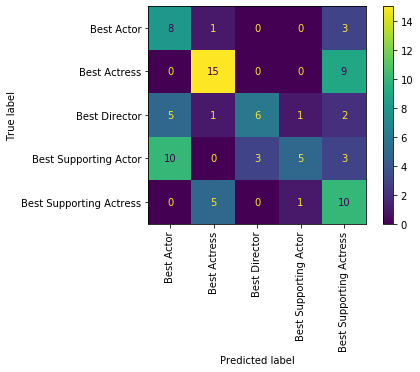

Accuracy score for training data is: 0.736
Accuracy score for test data: 0.500
Cross validation mean scores:0.4735068710359408
Cross validation mean scores: [0.38636364 0.36363636 0.43181818 0.40909091 0.52272727 0.60465116
 0.51162791 0.55813953]


In [84]:

clf = RandomForestClassifier(n_estimators=1000,max_depth=10)

#applying our classifier on the on our training set 
clf.fit(X_train, y_train)

plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

#outputing the value of our accuracy 
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)

print("Cross validation mean scores:{}".format(scores.mean()))
print("Cross validation mean scores:",scores)


In [85]:
#importing KMeans
from sklearn.cluster import KMeans

In [86]:
cluster = dataset[['race_ethnicity', 'award_age','birthplace','award_age','award','sexual_orientation']]
cluster = pd.get_dummies(cluster, columns = ['race_ethnicity','birthplace','award','sexual_orientation'])

## normalisation of the data
cluster = (cluster - cluster.min()) / (cluster.max() - cluster.min())

#print ('raw data', df.head(2))
cluster.head(2)

,award_age,award_age,race_ethnicity_0.0,race_ethnicity_1.0,race_ethnicity_2.0,race_ethnicity_3.0,race_ethnicity_4.0,race_ethnicity_5.0,"birthplace_Arlington, USA","birthplace_Astoria, USA",...,award_Best Actress,award_Best Director,award_Best Supporting Actor,award_Best Supporting Actress,sexual_orientation_0.0,sexual_orientation_1.0,sexual_orientation_2.0,sexual_orientation_3.0,sexual_orientation_4.0,sexual_orientation_5.0
0,0.225806,0.225806,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.419355,0.419355,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [87]:
#importing train_test_split
from sklearn.model_selection import train_test_split

In [88]:
km = KMeans(random_state=10, max_iter=500)
km.fit(cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

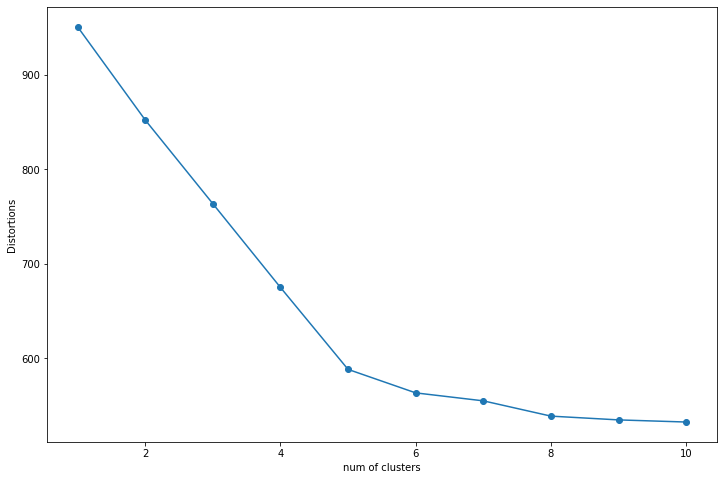

In [95]:
distortions = []
for i in range(1, 11):#iterating through the set range 
    km = KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, random_state=0)
    km.fit(cluster)
    distortions.append(km.inertia_)

#graph
plt.figure(figsize=(12,8))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('Distortions')
plt.show()

## PCA CLUSTERS

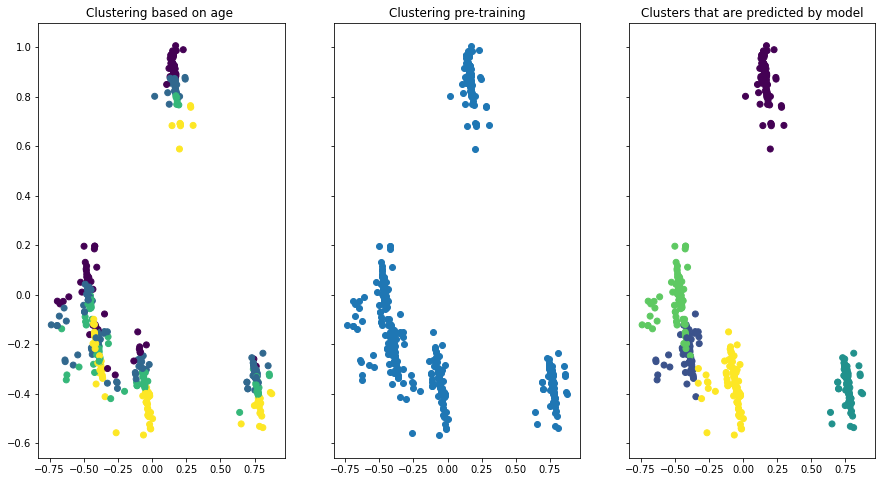

In [103]:
#implementation of pca clusters


import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

pca = PCA (2)
km = KMeans(n_clusters=5, random_state=10 , max_iter=500)

km.fit(cluster)

predicted = km.predict(cluster)

f,(ax1, ax2,ax3) = plt.subplots(1,3,sharey = True, figsize=(15,8))

plot_columns = pca.fit_transform(cluster)
ax1.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=age_buckets)

ax2.scatter(x=plot_columns[:,1], y=plot_columns[:,0])

ax3.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=predicted)

ax1.title.set_text("Clustering based on age ")

ax2.title.set_text("Clustering pre-training")

ax3.title.set_text("Clusters that are predicted by model")

plt.show()

